# Doing Bayesian Data Analysis

An example from __Chapter 18__.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
from scipy import stats as st

import matplotlib.pyplot as plt
import seaborn as sns

# Kruschke's light blue color
sns.set_palette(["#87ceeb"])
sns.set_context("talk")

In [2]:
df = pd.read_csv("data/Guber1999data.csv")
print len(df)
df.head()

50


,State,Spend,StuTeaRat,Salary,PrcntTake,SATV,SATM,SATT
0,Alabama,4.405,17.2,31.144,8,491,538,1029
1,Alaska,8.963,17.6,47.951,47,445,489,934
2,Arizona,4.778,19.3,32.175,27,448,496,944
3,Arkansas,4.459,17.1,28.934,6,482,523,1005
4,California,4.992,24.0,41.078,45,417,485,902


In [5]:
X = df[["Spend", "PrcntTake"]]
y = df["SATT"]

# A little bit convoluted with the two columns
zx = ((X - X.mean().values) / X.std().values).values
zy = (y - y.mean()) / y.std()

In [7]:
n_cols = 2
with pm.Model() as model:
    # Priors
    beta_0 = pm.Normal("beta_0", mu=0, tau=1E-8)
    beta_1 = pm.Normal("beta_1", mu=0, tau=1E-8, shape=n_cols)
    theta = beta_0 + tt.dot(beta_1, zx.T)

    sigma = pm.HalfCauchy("sigma", 25)    # Gelman 2006
    nu = pm.Exponential("nu", 1.0 / 29)   # Taken from the book
    # Likelihood
    y = pm.StudentT("y", nu=nu, mu=theta, sd=sigma, observed=zy)
    # Sample
    start = pm.find_MAP()
    step = pm.NUTS()
    trace = pm.sample(10000, step, start)
    
burn_in = 5000
trace = trace[burn_in:]

Optimization terminated successfully.
         Current function value: 63.544868
         Iterations: 16
         Function evaluations: 27
         Gradient evaluations: 27


100%|██████████| 10000/10000 [08:27<00:00, 19.69it/s]


                mean         sd  mc_error   hpd_2.5   hpd_97.5
beta_0     -0.000607   0.062578  0.000959 -0.126426   0.121736
beta_1__0   0.235206   0.079892  0.001501  0.070509   0.385239
beta_1__1  -1.032067   0.079398  0.001269 -1.190290  -0.877930
sigma       0.420851   0.050556  0.001762  0.329599   0.523970
nu         32.095827  26.081744  1.487837  2.813263  86.289677


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x116f94250>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1172fca50>]], dtype=object)

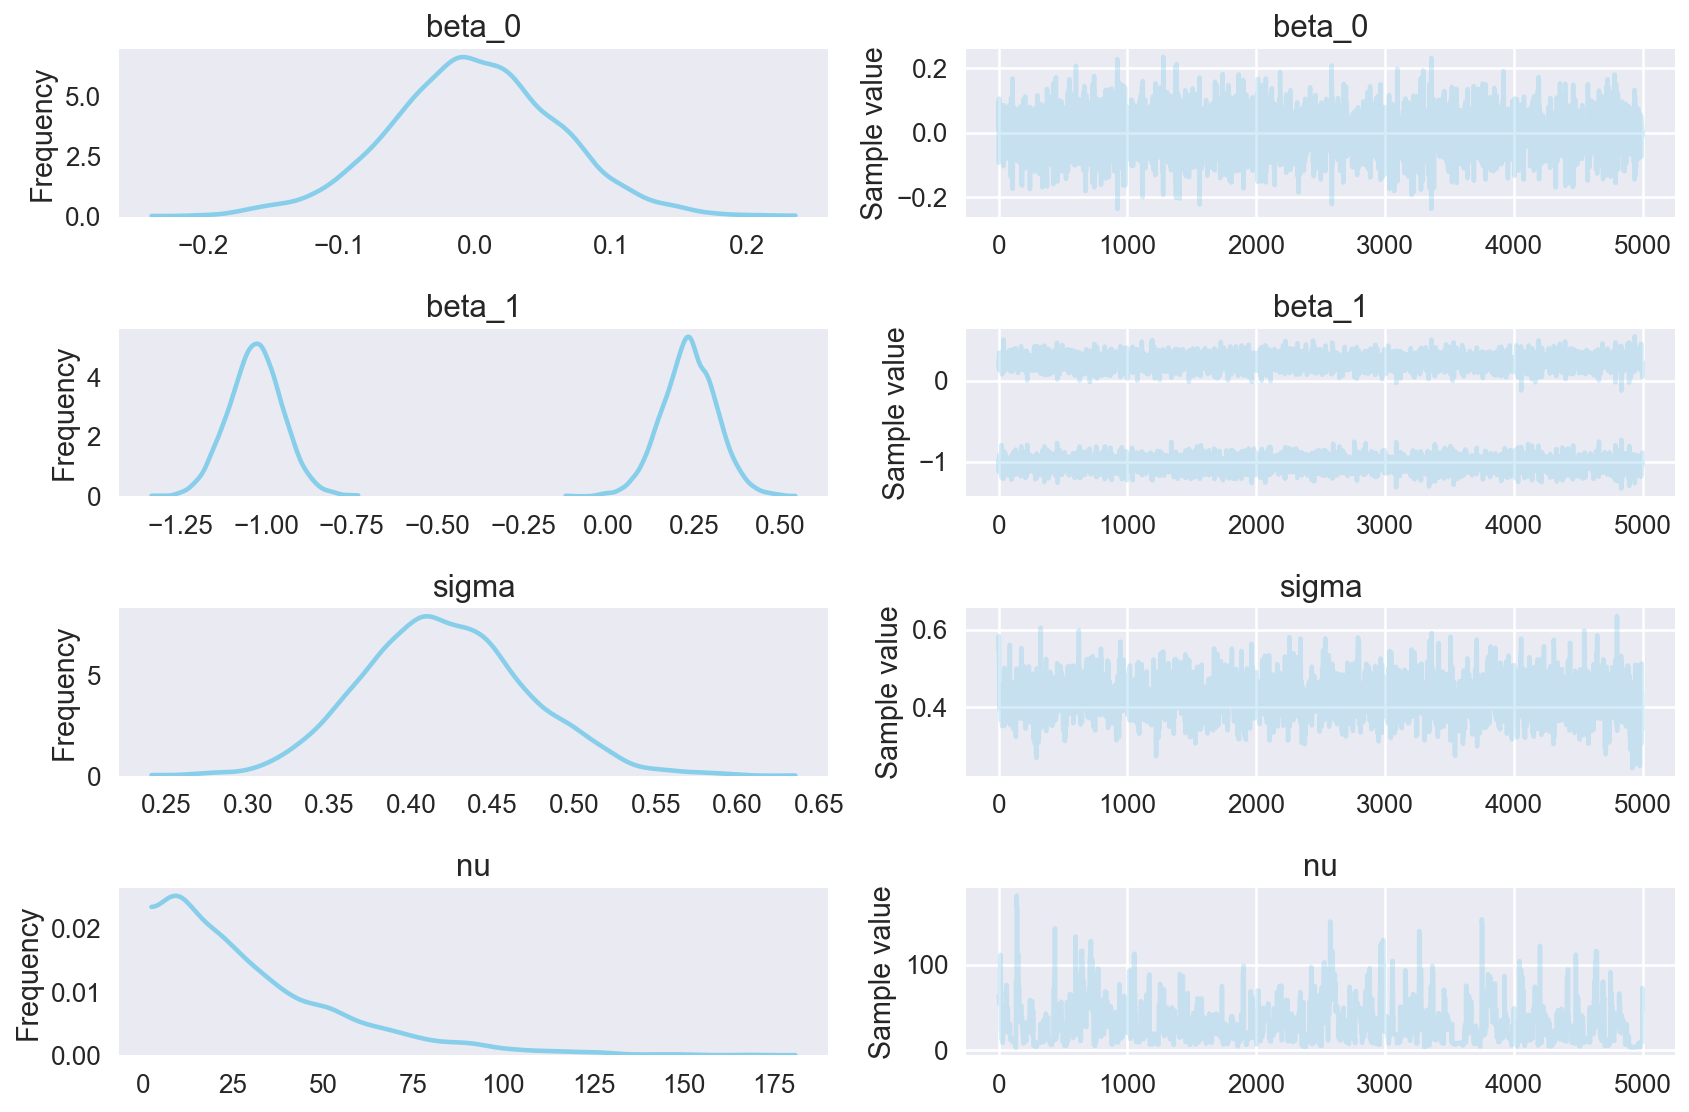

In [8]:
print(pm.df_summary(trace))
pm.traceplot(trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11771b4d0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x118a92cd0>], dtype=object)

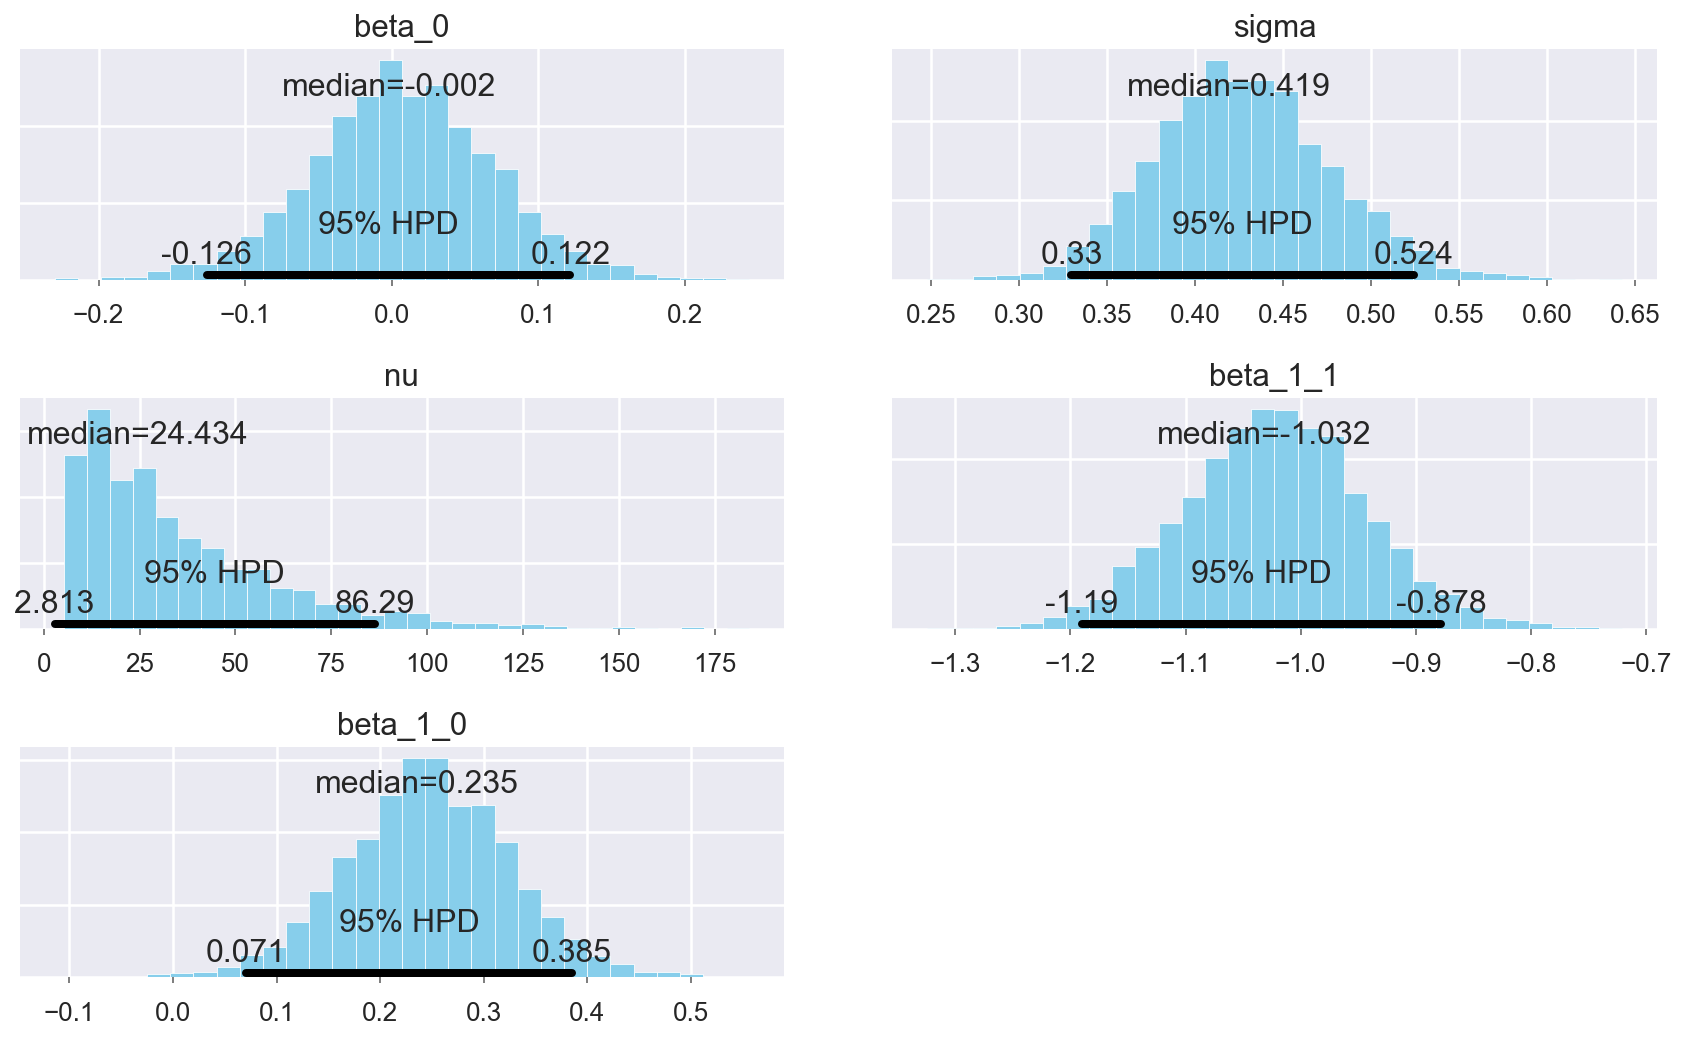

In [9]:
pm.plot_posterior(trace, point_estimate="median")

### Redundant Predictors

In [22]:
X["PropNotTake"] = (100 - X["PrcntTake"]) / 100
X.head()

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,Spend,PrcntTake,PropNotTake
0,4.405,8,0.92
1,8.963,47,0.53
2,4.778,27,0.73
3,4.459,6,0.94
4,4.992,45,0.55


In [29]:
zx_2 = ((X - X.mean().values) / X.std().values).values
zx_2[:5]

array([[-1.10086058, -1.0178453 ,  1.0178453 ],
       [ 2.24370805,  0.4394222 , -0.4394222 ],
       [-0.82716069, -0.30789447,  0.30789447],
       [-1.06123647, -1.09257697,  1.09257697],
       [-0.6701318 ,  0.36469053, -0.36469053]])

In [30]:
# We added that redundant column...
n_cols = 3
with pm.Model() as redundant_model:
    # Priors
    beta_0 = pm.Normal("beta_0", mu=0, tau=1E-8)
    beta_1 = pm.Normal("beta_1", mu=0, tau=1E-8, shape=n_cols)
    theta = beta_0 + tt.dot(beta_1, zx_2.T)

    sigma = pm.HalfCauchy("sigma", 25)    # Gelman 2006
    nu = pm.Exponential("nu", 1.0 / 29)   # Taken from the book
    # Likelihood
    y = pm.StudentT("y", nu=nu, mu=theta, sd=sigma, observed=zy)
    # Sample
    step = pm.Metropolis()
    trace = pm.sample(10000, step)

burn_in = 5000
trace = trace[burn_in:]


100%|██████████| 10000/10000 [00:04<00:00, 2451.38it/s]

                mean         sd  mc_error   hpd_2.5   hpd_97.5
beta_0      0.000315   0.064447  0.001862 -0.118268   0.132881
beta_1__0   0.233983   0.078867  0.004173  0.087800   0.394332
beta_1__1   2.629646   1.409915  0.140385  0.418751   5.184328
beta_1__2   3.660359   1.413009  0.140657  1.517704   6.291654
sigma       0.422017   0.051728  0.001812  0.317451   0.516348
nu         33.389106  29.102537  0.899790  2.010767  92.781714


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11d684490>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x116b44210>]], dtype=object)

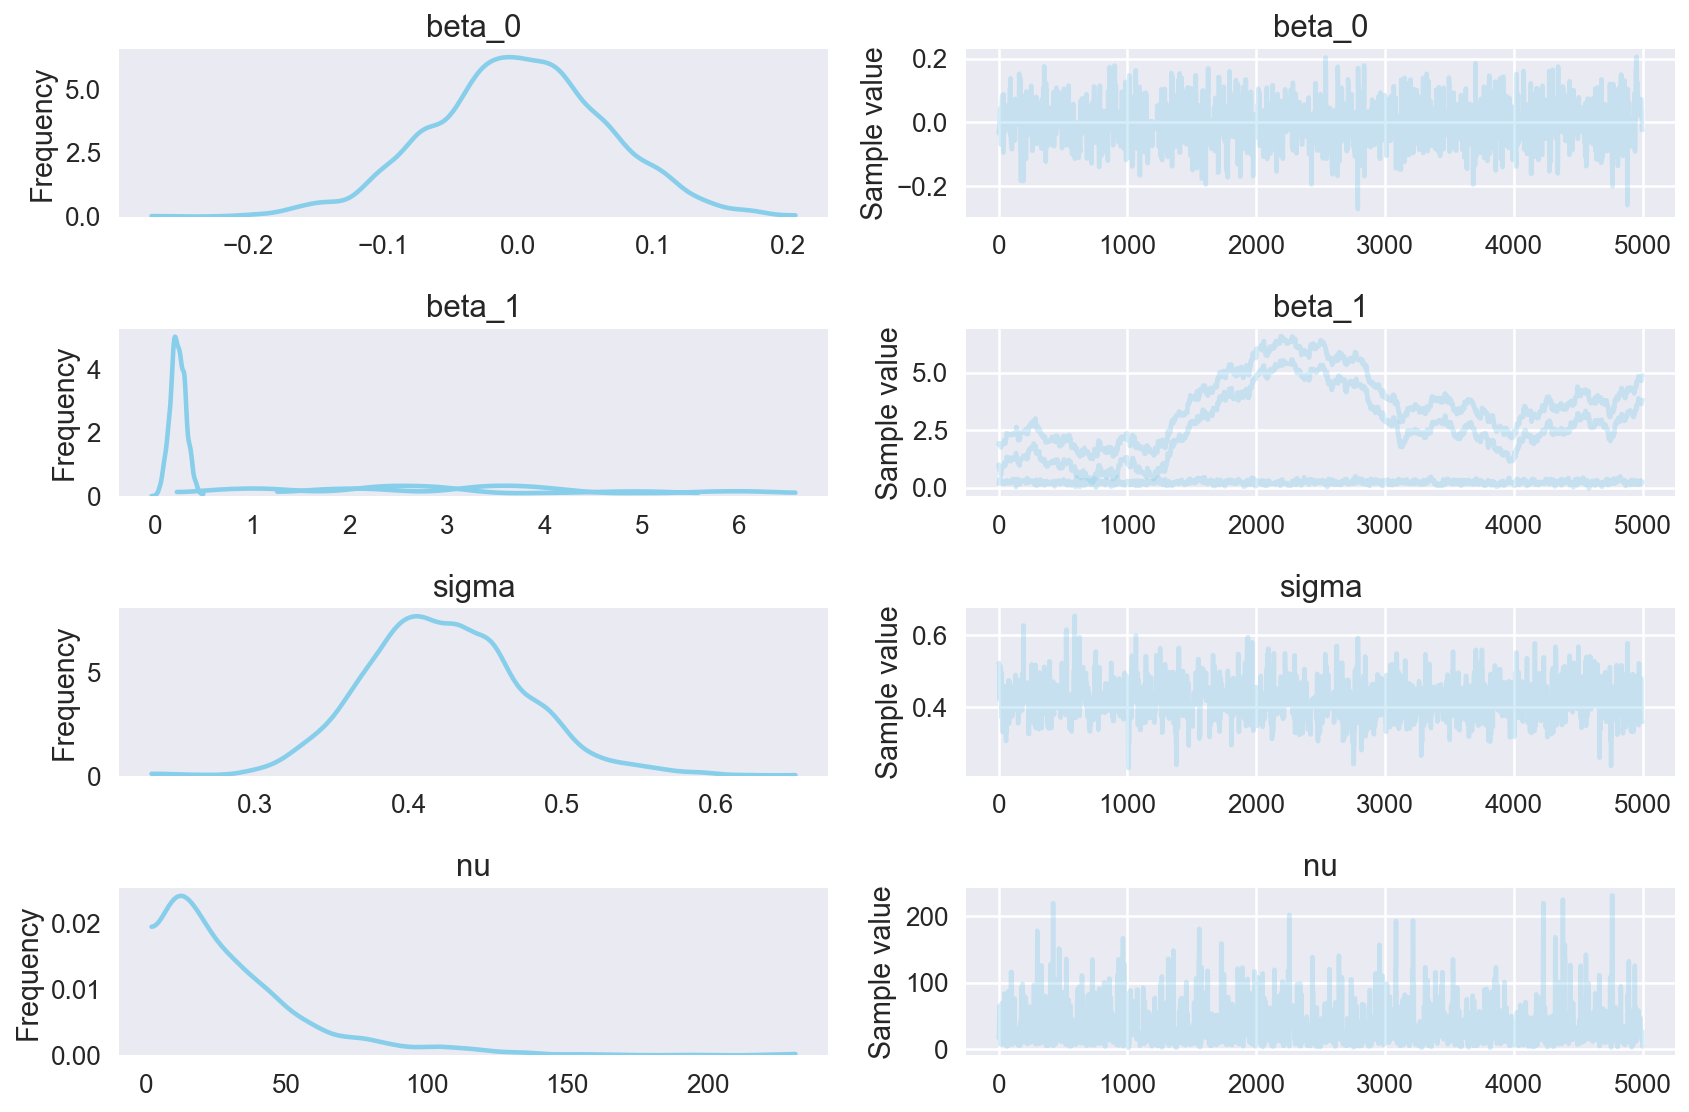

In [31]:
print(pm.df_summary(trace))
pm.traceplot(trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x116e44150>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x11ef79e50>], dtype=object)

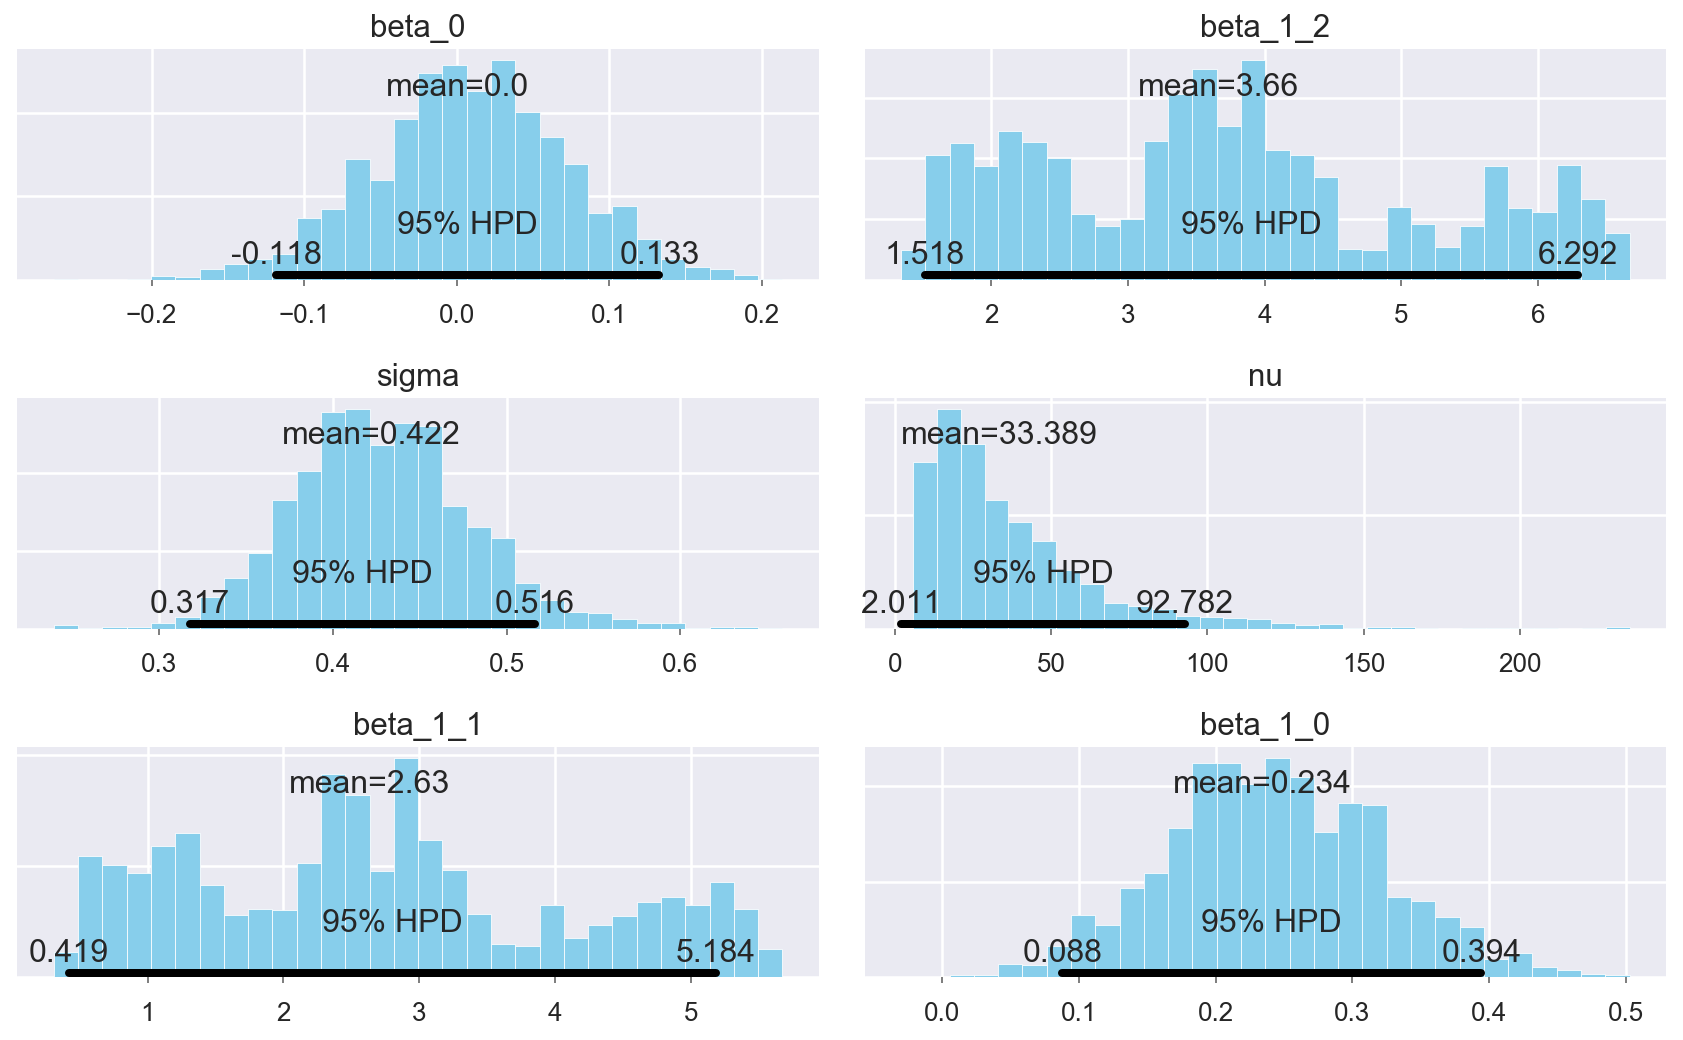

In [32]:
pm.plot_posterior(trace)